In [37]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler,StandardScaler,Normalizer,RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error
from sklearn.metrics import accuracy_score

import keras
import sklearn
from sklearn.utils import class_weight
import tensorflow.compat.v1 as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.models import Input
from keras.layers import Dense,LSTM,Dropout,Flatten,Conv1D,MaxPool1D,AlphaDropout
from keras.layers import Permute,Reshape,RepeatVector,Multiply,Lambda,merge,BatchNormalization
from tensorflow.keras.layers import Attention
from keras import backend as K
from keras import regularizers
from keras.initializers import he_normal,lecun_normal,RandomNormal,glorot_normal,glorot_uniform
import keras.applications.resnet

from keras.layers import Embedding
from keras.layers import concatenate
from keras.layers import GaussianNoise,GaussianDropout
#时序交叉验证
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
#from sklearn.utils import shuffle
import time
import os
import matplotlib.pyplot as plt
import re


In [38]:
#####参数
global time_step,n_pred
time_step =20# 用100步预测未来-----time_steps
n_pred = 1  # 预测未来1步

#n_features = 9# 特征数
#对部分特征进行one_hot编码
#特征数从官方信息以及预处理文件中得到

#n_stu_features=1*3+1*8+1
global n_weather,n_address,cols
n_weather=7#
weather_list=['无','多云', '晴', '霾', '雨夹雪', '阴', '小雨']
n_address=10
cols=0

###网络参数
#embedding
static_emb_size=100

#lstm
lstm1_cell =128
lstm2_cell =128
lstm2_cell = 64

#action_statistic--hidden
#cnn
cnn_filter=128
kernel_sizes=1
#hidden
static_hidden1_cell=128
static_hidden2_cell=64
#
#特征融合--dense
hidden1_cell=128#和lstm_cell一样，要拼接
hidden2_cell=128

#attn
SINGLE_ATTENTION_VECTOR=False
#out
n_output_reg_cell = 1  # 回归
n_output_clas_cell = n_address # 分类(onehot),使用onehot编码分类树为编码长度

#training
epochs = 25#30
batch_size =8
#lr=0.001

In [39]:
#提前终止
from keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(monitor='val_out_clas_accuracy',patience=6,mode='max')

#loss出现nan停止训练
from keras.callbacks import TerminateOnNaN
nan_stoping=TerminateOnNaN()

In [40]:
# Define our custom loss function
#regression
def huber(y_true, y_pred, delta=1):
    #return tf.reduce_mean(tf.square(true-pred)) with tf.Session() as sess:
    loss = tf.where(tf.abs(y_true-y_pred) < delta , 0.5*((y_true-y_pred)**2), delta*tf.abs(y_true - y_pred) - 0.5*(delta**2))
    #reduce_sum()中就是按照求和的方式对矩阵降维
    #reduce_mean()就是按照某个维度求平均值
    # K.sum(loss)
    return tf.reduce_sum(loss)
#classifoication
def focal_loss_softmax(y_true, y_pred,gamma=2.0,epsilon=1e-6):
    #多分类中alpha没用
    #alpha =0.25
    y_true=tf.convert_to_tensor(y_true,tf.float32)
    y_pred=tf.convert_to_tensor(y_pred,tf.float32)
    
    model_out=tf.add(y_pred,epsilon)
    ce=tf.multiply(y_true,-tf.log(model_out))
    weight=tf.multiply(y_true,tf.pow(tf.subtract(1.,model_out),gamma))
    fl=tf.multiply(1.,tf.multiply(weight,ce))
    reduce_fl=tf.reduce_max(fl,axis=1)
    return tf.reduce_mean(reduce_fl)
    
def focal_loss(y_true, y_pred,gamma=2.0,epsilon=1e-8):
   
    alpha =tf.constant([[0.15],[0.35],[0.45],[0.05],[0.2]],dtype=tf.float32)
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+epsilon))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0+epsilon))

In [41]:
#define optimizer
#前5个epoch学习率保持不变，5个之后学习率按照指数进行衰减
def lr_decay(epoch):
    lr=0.005
    if epoch < 3:
        return lr
    elif epoch<10:
        return lr/10
    elif epoch<15: 
        return lr/100
    elif epoch<20: 
        return lr/500
    else:
        return lr/5000
        #return lr*tf.math.exp(0.1*(epochs-epoch))

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay)

In [42]:
#存储最佳权重
from keras.callbacks import ModelCheckpoint
checkpoint_filepath='best_weight_model-step30.hdf5'
print(checkpoint_filepath)
weight_callback = ModelCheckpoint( #创建回调
    filepath=checkpoint_filepath, #告诉回调要存储权重的filepath在哪
    save_weights_only=True, #只保留权重(更有效)，而不是整个模型
    monitor='val_out_clas_accuracy', #度量
    mode='max', #找出使度量最大化的模型权重
    save_best_only=True #只保留最佳模型的权重(更有效)，而不是所有的权重
)

best_weight_model-step30.hdf5


In [43]:
date='2021/11/28 19:03:00'
hour = re.search('(\d+)/(\d+)/(\d+) (\d+):(\d+):(\d+)',date).group(4)
print(hour)

19


In [44]:
#对时间步的attention
def attention_time_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)#行列互换，求矩阵inputs的转置
    a = Reshape((input_dim, time_step))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(time_step, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_time_vec')(a)
    time_attention_out= Multiply()([inputs, a_probs])                                        
    return time_attention_out

In [45]:
#数据增强
def wgn(x, snr):
    #print(x)
    
    batch_size, len_x = x.shape
    Ps = np.sum(np.power(x, 2)) / len_x
    Pn = Ps / (np.power(10, snr / 10))
    noise = np.random.randn(len_x) * np.sqrt(Pn)
    #print(x + noise)
    return x + noise

In [46]:
def data_process(data):
    cols=list(data)
    #weather属性处理 
    data.weather[(data.weather=='999')|(data.weather=='0')]="无"
    #['多云', '晴', '霾', '无', '雨夹雪', '阴', '小雨'] 
    for i, row in data.iterrows():
        hour = float(re.search('(\d+)-(\d+)-(\d+) (\d+):(\d+):(\d+)',row.start_time).group(4))
        data.loc[i,'start_time'] = hour
        #data.loc[i,'floor'] = int(data.loc[i,'floor'])
        data.loc[i,'weather']=weather_list.index(row.weather)
        data.loc[i,'19_sensor_value1']=(data.loc[i,'19_sensor_value1'])/10000
        #ata.loc[i,'5_sensor_value1.1']=abs(data.loc[i,'5_sensor_value1.1'])
        #ata.loc[i,'3_sensor_value2']=abs(data.loc[i,'3_sensor_value2'])
        #ata.loc[i,'3_sensor_value3']=abs(data.loc[i,'3_sensor_value3'])
        if row.time_span>100:
            data.loc[i,'time_span']=100
        if row.time_span<1:
            data.loc[i,'time_span']=1  
        data.loc[i,'time_span']=(data.loc[i,'time_span'])/60
        if row.time_interval>120:
            data.loc[i,'time_interval']=120
        data.loc[i,'time_interval']=(data.loc[i,'time_interval'])/60
            
    data.loc[:,'address':'weather'].astype('float64')
    data.loc[:,'5_sensor_value1.1':].astype('float64')
    
    #数据集划分
    all_scale=data.values.shape[0]
    train_scale = int(all_scale * 0.4)
    test_scale = all_scale - train_scale
    
    #数据增强
    train_data=pd.DataFrame()
    noise_data=pd.DataFrame()
    test_data=data.loc[:,'address':]
    
    address_data=data.loc[train_scale:,'address':'start_time']
    weather_data=data.loc[train_scale:,'weather']
    data1=data.loc[train_scale:,'time_span':'floor']
    data2=data.loc[train_scale:,'5_sensor_value1.1':]

    snr = 20
    for i in range(30):
        data1_noise = wgn(data1, snr)
        data2_noise = wgn(data2, snr)

        noise_data = pd.concat([address_data, data1_noise], axis=1)
        noise_data = pd.concat([noise_data, weather_data], axis=1)
        noise_data = pd.concat([noise_data, data2_noise], axis=1)
        if i==0:
            train_data=noise_data
        else:
            train_data=pd.concat([train_data, noise_data], axis=0)
    
    train_data_value = train_data.values
    #data_value = data.values
    onehot_weather_encoder=to_categorical(train_data_value[:,cols.index('weather')], n_weather)
    onehot_address_encoder=to_categorical(train_data_value[:,cols.index('address')], n_address)
    
    train_value=np.concatenate((onehot_address_encoder,train_data_value[:,cols.index('address')+1:cols.index('weather')]), axis=1)
    train_value=np.concatenate((train_value,onehot_weather_encoder), axis=1)
    train_value=np.concatenate((train_value,train_data_value[:,cols.index('weather')+1:]), axis=1)
    
    test_data_value = test_data.values
    #data_value = data.values
    onehot_weather_encoder=to_categorical(test_data_value[:,cols.index('weather')], n_weather)
    onehot_address_encoder=to_categorical(test_data_value[:,cols.index('address')], n_address)
    
    test_value=np.concatenate((onehot_address_encoder,test_data_value[:,cols.index('address')+1:cols.index('weather')]), axis=1)
    test_value=np.concatenate((test_value,onehot_weather_encoder), axis=1)
    test_value=np.concatenate((test_value,test_data_value[:,cols.index('weather')+1:]), axis=1)
    return cols,train_value,test_value


In [47]:
# 构造nstep->n_pred的监督型数据,n_steo组数据预测n_pred组
# 隐式添加时序信息
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_dcol = 1 if type(data) is list else data.shape[1]  # data列数
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # 输入序列（t-n,...,t-1）
    # 将三组输入数据依次向下移动n,n-1,..,1行，将数据加入cols列表
    # var1----var7表示action(one-hot)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_dcol)]
    # 预测序列（t，t+1,t+n）
    # 将一组数据加入cols列表
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_dcol)]
        else:
            names += [('var%d(t+i)' % (j + 1)) for j in range(n_dcol)]
    # 将数据列表（cols）中现有的time_step+n_pred块（df-n_in,df-n_in+1,...df-1,df,..,df+n_pred+1）按列合并
    agg = pd.concat(cols, axis=1)
    # 为合并后的数据添加列名
    agg.columns = names
    
    #移位后产生的NaN值补0
    #agg.fillna(0,inplace=True)
    print(data.shape)
    print('agg:',agg.shape)
    # 删除NaN值
    if dropnan:
        agg.dropna(inplace=True)  # dropna()
    agg = agg.reset_index(drop=True)  # 删除原始索引，否则会生成一列index
    
    return agg 

In [48]:
print(int('1'))

1


In [49]:
read_dir = 'F:\\DeepLearning\\DataSet\\mobile_data\\SnnuLog\\process\\process\\data'
user_list = os.listdir(read_dir)
user_train_data=pd.DataFrame()
user_test_data=pd.DataFrame()
user_i = 1
for user in user_list:
    # 加载数据
    #, usecols=['name','weather']
    #dataset = pd.read_csv(os.path.join(read_dir, user),sep=',', usecols=['address','start_time','time_span','time_interval','floor','weather','5_sensor_value1.1','5_sensor_value2.1','5_sensor_value3.1','19_sensor_value1'],encoding='gbk',engine='python')
    dataset = pd.read_csv(os.path.join(read_dir, user),sep=',', usecols=['address','start_time','time_span','time_interval','floor','weather','5_sensor_value1.1','5_sensor_value2.1','5_sensor_value3.1','19_sensor_value1'],encoding='gbk',engine='python')
    
    #dataset = pd.read_csv(os.path.join(read_dir, user))
    dataset.dropna(axis=0,how='any',inplace = True)
    #sub(模式串，（去替换模式串的字符串），主串)
    en_id=re.sub('.csv','',user) 
    if len(dataset) <=time_step*0.5:
        continue
    #数据处理
    print(user)
    cols,train_value,test_value= data_process(dataset)
    train_value  = train_value.astype('float32')
    test_value  = test_value.astype('float32')
    
    # 构造监督型时序数据time_step---->n_pred
    train_data_reframed = series_to_supervised(train_value, time_step, n_pred)
    test_data_reframed = series_to_supervised(test_value, time_step, n_pred)
    #list1=data['weather'].drop_duplicates().values.tolist()
    #print(user,":  ",list1,"   ",len(list1))
    
    if user_i == 1:
        user_train_data= train_data_reframed 
        user_test_data= test_data_reframed 
    else:
        user_train_data = pd.concat((user_train_data, train_data_reframed ), axis=0)
        user_test_data = pd.concat((user_test_data, test_data_reframed ), axis=0)
    #if len(dataset) >= time_step:
        #user_i += 1
    user_i += 1
user_train_data = user_train_data.reset_index(drop=True)  
user_test_data = user_test_data.reset_index(drop=True)  
#list1=all_user_data['weather'].drop_duplicates().values.tolist()
#print(list1,"   ",len(list1))

Tom1.csv


D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(1140, 25)
agg: (1140, 525)
(63, 25)
agg: (63, 525)
Tom10.csv
(1410, 25)
agg: (1410, 525)
(77, 25)
agg: (77, 525)
Tom11.csv
(420, 25)
agg: (420, 525)
(22, 25)
agg: (22, 525)
Tom12.csv
(450, 25)
agg: (450, 525)
(24, 25)
agg: (24, 525)
Tom13.csv
(330, 25)
agg: (330, 525)
(18, 25)
agg: (18, 525)
Tom16.csv
(1230, 25)
agg: (1230, 525)
(67, 25)
agg: (67, 525)
Tom17.csv
(1140, 25)
agg: (1140, 525)
(62, 25)
agg: (62, 525)
Tom18.csv
(990, 25)
agg: (990, 525)
(55, 25)
agg: (55, 525)
Tom20.csv
(240, 25)
agg: (240, 525)
(12, 25)
agg: (12, 525)
Tom21.csv
(810, 25)
agg: (810, 525)
(45, 25)
agg: (45, 525)
Tom22.csv
(2250, 25)
agg: (2250, 525)
(125, 25)
agg: (125, 525)
Tom23.csv
(1050, 25)
agg: (1050, 525)
(58, 25)
agg: (58, 525)
Tom25.csv
(870, 25)
agg: (870, 525)
(48, 25)
agg: (48, 525)
Tom26.csv
(240, 25)
agg: (240, 525)
(12, 25)
agg: (12, 525)
Tom27.csv
(690, 25)
agg: (690, 525)
(38, 25)
agg: (38, 525)
Tom28.csv
(810, 25)
agg: (810, 525)
(44, 25)
agg: (44, 525)
Tom3.csv
(1500, 25)
agg: (1500, 525)

In [50]:
user_train_data

,var1(t-20),var2(t-20),var3(t-20),var4(t-20),var5(t-20),var6(t-20),var7(t-20),var8(t-20),var9(t-20),var10(t-20),...,var16(t),var17(t),var18(t),var19(t),var20(t),var21(t),var22(t),var23(t),var24(t),var25(t)
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.042410,0.207331,9.446427,0.263226
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.133394,0.328085,9.447031,1.011226
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,-2.473793,-8.850556,-3.211002,0.493426
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,-0.326105,-0.050378,9.441134,0.698826
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.460538,-9.345383,-2.405728,0.219226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24335,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.535130,0.118842,11.681606,0.773344
24336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,4.688187,6.050137,-2.638095,0.960244
24337,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,-2.159375,-2.022531,11.519955,0.960244
24338,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.186545,-0.587816,11.748747,1.055744


In [51]:
user_test_data

,var1(t-20),var2(t-20),var3(t-20),var4(t-20),var5(t-20),var6(t-20),var7(t-20),var8(t-20),var9(t-20),var10(t-20),...,var16(t),var17(t),var18(t),var19(t),var20(t),var21(t),var22(t),var23(t),var24(t),var25(t)
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,5.852271,-5.315169,-5.802611,0.3774
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.885722,-9.753509,-0.504924,0.4304
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-2.068436,2.367491,9.289077,0.4700
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.317945,3.750479,8.964782,0.3999
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.203499,0.189657,9.802704,1.0257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.387289,1.252911,9.718572,0.1038
791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,4.836029,7.184206,-4.601130,0.2907
792,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,-2.011534,-0.888462,9.556921,0.2907
793,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.334386,0.546253,9.785713,0.3862


In [52]:
#数据转换
train_values = user_train_data.values
test_values = user_test_data.values
print(train_values.shape,test_values.shape)

(24340, 525) (795, 525)


In [53]:

features=train_values.shape[1]-(len(cols)-2+n_weather+n_address)


# 分割训练集、验证集和测试集6:2:2
# x, y = sklearn.utils.shuffle(X, Y)
#all_value_shuffle= sklearn.utils.shuffle(all_value,random_state=1) 
#shuffle
#value_train=all_value_shuffle[:train_scale,:]
#value_val=all_value_shuffle[train_scale:train_scale + val_scale,:]
#value_test=all_value_shuffle[train_scale + val_scale:,:]


scaler=MinMaxScaler(feature_range=(0,1)).fit(train_values)
scaled_value_train=scaler.transform(train_values)
scaled_value_test=scaler.transform(test_values)

In [54]:
print(cols)

['address', 'start_time', 'time_span', 'time_interval', 'floor', 'weather', '5_sensor_value1.1', '5_sensor_value2.1', '5_sensor_value3.1', '19_sensor_value1']


In [55]:
print(features)

500


In [56]:
scaled_trainX, scaled_train_Yclass,scaled_train_Ytp,scaled_train_Yti = scaled_value_train[:, :features],scaled_value_train[:,features:features+n_address],scaled_value_train[:,features+n_address+1:features+n_address+2],scaled_value_train[:,features+n_address+2:features+n_address+3]
scaled_testX, scaled_test_Yclass,scaled_test_Ytp,scaled_test_Yti = scaled_value_test[:, :features],scaled_value_test[:,features:features+n_address],scaled_value_test[:,features+n_address+1:features+n_address+2],scaled_value_test[:,features+n_address+2:features+n_address+3]

#
scaled_trainX_re=scaled_trainX.reshape((scaled_trainX.shape[0], time_step,(len(cols)-2+n_weather+n_address)))
scaled_testX_re=scaled_testX.reshape((scaled_testX.shape[0], time_step,(len(cols)-2+n_weather+n_address)))
print(scaled_trainX.shape)

(24340, 500)


In [57]:
print(scaled_testX.shape)

(795, 500)


In [58]:
#决策树
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

Dt_model = DecisionTreeClassifier(criterion='entropy').fit(scaled_trainX,scaled_train_Yclass)
Dt_predictY= Dt_model .predict(scaled_testX)



In [59]:
clas_test_pred=Dt_predictY

In [60]:
print(Dt_predictY )
print(scaled_test_Yclass)
yhat_class = np.argmax(Dt_predictY, axis=-1).astype('int')  # 返回最大数的索引
yclas = np.argmax(scaled_test_Yclass, axis=-1).astype('int')
acc = accuracy_score(yclas,yhat_class)
print("DT_model:acurracy:%.3f" % (acc*100),'%')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
DT_model:acurracy:67.421 %


              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000         0
           1    0.65079   0.66667   0.65863       123
           2    0.57143   0.55814   0.56471        43
           3    0.71098   0.70690   0.70893       174
           4    0.58333   0.51220   0.54545        41
           5    0.66393   0.64286   0.65323       126
           6    0.66667   0.78261   0.72000        23
           7    0.66082   0.70625   0.68278       160
           8    0.68421   0.70270   0.69333        37
           9    0.80000   0.70588   0.75000        68

   micro avg    0.67421   0.67421   0.67421       795
   macro avg    0.59922   0.59842   0.59771       795
weighted avg    0.67507   0.67421   0.67393       795
 samples avg    0.67421   0.67421   0.67421       795



D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


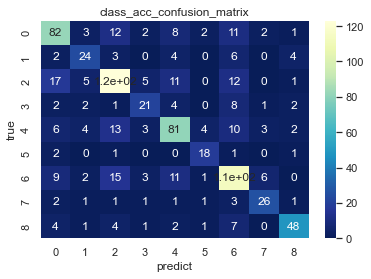

In [61]:
#计算混淆矩阵
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
#统计每个类别的预测准确率、召回率、F1-score
print(classification_report(Dt_predictY,scaled_test_Yclass,digits=5))
#计算混淆矩阵
confusion_mat=confusion_matrix(yhat_class,yclas)
sns.set()
figure,ax=plt.subplots()
sns.heatmap(confusion_mat,cmap='YlGnBu_r',annot=True,ax=ax)
#标题
ax.set_title('class_acc_confusion_matrix')
#x轴为预测类别
ax.set_xlabel('predict')
#y为实际类别
ax.set_ylabel('true')
#在 plt.show() 之前调用 plt.savefig()
#plt.savefig('./other_methods_pic/2lstm_confusion_mat.png')
plt.show()

D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_ranking.py:813: U

Precision_score: 0.6761728155899239


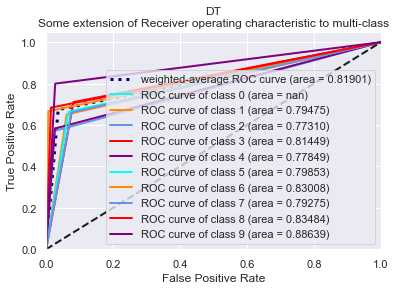

In [62]:
#roc
from sklearn import metrics
from sklearn.metrics import recall_score,accuracy_score
from sklearn.metrics import precision_score,f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle

class_test_one_hot = label_binarize(yclas, classes=np.arange(n_address))
class_test_one_hot_hat=label_binarize(yhat_class, classes=np.arange(n_address))
# weighted：不均衡数量的类来说，计算二分类metrics的平均
precision = precision_score(class_test_one_hot , class_test_one_hot_hat, average='weighted')
recall = recall_score(class_test_one_hot , class_test_one_hot_hat, average='weighted')
f1_score = f1_score(class_test_one_hot , class_test_one_hot_hat, average='weighted')
accuracy_score = accuracy_score(class_test_one_hot , class_test_one_hot_hat)
print("Precision_score:",precision)


# roc_curve:真正率（True Positive Rate , TPR）或灵敏度（sensitivity）
# 横坐标：假正率（False Positive Rate , FPR）
 
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_address):
    fpr[i], tpr[i], _ = roc_curve(class_test_one_hot[:, i], class_test_one_hot_hat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute weight-average ROC curve and ROC area
fpr["weighted"], tpr["weighted"], _ = roc_curve(class_test_one_hot.ravel(), class_test_one_hot_hat.ravel())
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

# Plot all ROC curves
lw = 2
plt.figure()
plt.plot(fpr["weighted"], tpr["weighted"],
  label='weighted-average ROC curve (area = {0:0.5f})'
  ''.format(roc_auc["weighted"]),
  color='navy', linestyle=':', linewidth=3)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','purple'])
for i, color in zip(range(n_address), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DT\nSome extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
#plt.savefig("")
plt.show()

In [63]:
print(clas_test_pred)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [64]:
from sklearn.tree import  DecisionTreeRegressor #导入K近邻分类器
from sklearn.metrics import accuracy_score

DTR_model1 = DecisionTreeRegressor().fit(scaled_trainX,scaled_train_Ytp)   # 使用KNN算法进行训练并生成预处理结果
reg_tp_test_pred = DTR_model1.predict(scaled_testX)

In [65]:
from sklearn.tree import  DecisionTreeRegressor #导入K近邻分类器
from sklearn.metrics import accuracy_score

DTR_model2 = DecisionTreeRegressor().fit(scaled_trainX,scaled_train_Yti)   # 使用KNN算法进行训练并生成预处理结果
reg_ti_test_pred = DTR_model2.predict(scaled_testX)

In [66]:
print(reg_ti_test_pred)

[0.40962487 0.32976678 0.25824755 0.34375674 0.40684348 0.45908955
 0.35517806 0.73503596 0.51219314 0.73876947 0.73822212 0.7392965
 0.73489815 0.63051319 0.76083541 0.69104099 0.22738251 0.73754191
 0.34927851 0.62871051 0.31895229 0.34017387 0.31196788 0.33670765
 0.62871051 0.73489815 0.74746513 0.61496711 0.38916308 0.72988021
 0.34606645 0.76544327 0.35267934 0.73489815 0.73489815 0.40864262
 0.73489815 0.73489815 0.76667732 0.41904733 0.73489815 0.73489815
 0.33628339 0.38268697 0.73147893 0.73863316 0.71775019 0.42498344
 0.74347866 0.45613152 0.42780888 0.39277166 0.51810163 0.37442505
 0.57252538 0.69329333 0.44151959 0.63967419 0.27471271 0.34453264
 0.73205096 0.35522613 0.26610667 0.33973151 0.71659076 0.40644559
 0.32754099 0.73876947 0.39042872 0.39138103 0.73745441 0.40936348
 0.73156977 0.86762339 0.40193772 0.73156977 0.73754191 0.72877288
 0.76083541 0.36372265 0.73822212 0.73876947 0.6653989  0.7392965
 0.61135495 0.73850536 0.3880842  0.69948339 0.33518413 0.393592

In [67]:
# 逆缩放维度要求：n行*features列
#拼接之前需要知道开始怎么对数据进行拼接的
# 现进行数据拼接，再对预测数据进行逆缩放
# test_X=test_X.reshape(test_X.shape[0],n_step*n_features)

# 现进行数据拼接，再对真实数据进行逆缩放
inv_Ytrue_test = scaler.inverse_transform(scaled_value_test)
inv_Ytrue_train=scaler.inverse_transform(scaled_value_train)

#预测值缩放
reg_tp_test_pred = reg_tp_test_pred.reshape(len(reg_tp_test_pred), 1)
reg_ti_test_pred = reg_ti_test_pred.reshape(len(reg_ti_test_pred), 1)
test_st=scaled_value_test[:,features+n_address]
test_st = test_st.reshape(len(test_st), 1)

test_pred=np.concatenate((scaled_value_test[:,:features],clas_test_pred),axis=1)
test_pred=np.concatenate((test_pred,test_st),axis=1)
test_pred=np.concatenate((test_pred,reg_tp_test_pred),axis=1)
test_pred=np.concatenate((test_pred,reg_ti_test_pred),axis=1)
test_pred=np.concatenate((test_pred,scaled_value_test[:,features+n_address+3:]),axis=1)
inv_test_pred = scaler.inverse_transform(test_pred)

In [68]:
print(reg_ti_test_pred)

[[0.40962487]
 [0.32976678]
 [0.25824755]
 [0.34375674]
 [0.40684348]
 [0.45908955]
 [0.35517806]
 [0.73503596]
 [0.51219314]
 [0.73876947]
 [0.73822212]
 [0.7392965 ]
 [0.73489815]
 [0.63051319]
 [0.76083541]
 [0.69104099]
 [0.22738251]
 [0.73754191]
 [0.34927851]
 [0.62871051]
 [0.31895229]
 [0.34017387]
 [0.31196788]
 [0.33670765]
 [0.62871051]
 [0.73489815]
 [0.74746513]
 [0.61496711]
 [0.38916308]
 [0.72988021]
 [0.34606645]
 [0.76544327]
 [0.35267934]
 [0.73489815]
 [0.73489815]
 [0.40864262]
 [0.73489815]
 [0.73489815]
 [0.76667732]
 [0.41904733]
 [0.73489815]
 [0.73489815]
 [0.33628339]
 [0.38268697]
 [0.73147893]
 [0.73863316]
 [0.71775019]
 [0.42498344]
 [0.74347866]
 [0.45613152]
 [0.42780888]
 [0.39277166]
 [0.51810163]
 [0.37442505]
 [0.57252538]
 [0.69329333]
 [0.44151959]
 [0.63967419]
 [0.27471271]
 [0.34453264]
 [0.73205096]
 [0.35522613]
 [0.26610667]
 [0.33973151]
 [0.71659076]
 [0.40644559]
 [0.32754099]
 [0.73876947]
 [0.39042872]
 [0.39138103]
 [0.73745441]
 [0.40

In [69]:
#取整
#for i in range(0,len(inv_test_pred)):
    #inv_test_pred[i,(enroll_features-n_timespan)]=int(inv_test_pred[i,(enroll_features-n_timespan)])

In [70]:
# 计算回归模型RMSE误差值
#enroll_test_Y=np.power(2,enroll_test_Y)
#reg_yhat=np.power(2,reg_yhat)
print(inv_Ytrue_test[:,features+n_address+1].max())
print(inv_test_pred[:,features+n_address+1].max())

rmse = math.sqrt(mean_squared_error(abs(inv_Ytrue_test[:,(features+n_address+1)]),abs(inv_test_pred[:,(features+n_address+1)])))
print('Test timespan RMSE:%.3f' %rmse)
rmse = math.sqrt(mean_squared_error(abs(inv_Ytrue_test[:,(features+n_address+2)]),abs(inv_test_pred[:,(features+n_address+2)])))
print('Test timeint RMSE:%.3f' %rmse)

1.6666666
1.7207176165179294
Test timespan RMSE:0.448
Test timeint RMSE:0.779


In [71]:
mae = mean_absolute_error(abs(inv_Ytrue_test[:,(features+n_address+1)]),abs(inv_test_pred[:,(features+n_address+1)]))
print('Test timespan mae:%.3f' %mae)
mae = mean_absolute_error(abs(inv_Ytrue_test[:,(features+n_address+2)]),abs(inv_test_pred[:,(features+n_address+2)]))
print('Test timeint mae:%.3f' %mae)

Test timespan mae:0.153
Test timeint mae:0.457


In [72]:
mde = median_absolute_error(abs(inv_Ytrue_test[:,(features+n_address+1)]),abs(inv_test_pred[:,(features+n_address+1)]))
print('Test timespan mde:%.3f' %mae)
mde = median_absolute_error(abs(inv_Ytrue_test[:,(features+n_address+2)]),abs(inv_test_pred[:,(features+n_address+2)]))
print('Test timeint mde:%.3f' %mae)

Test timespan mde:0.457
Test timeint mde:0.457
